In [1]:
import habitat_sim

import random
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

In [2]:
test_scene = "../data/scene_datasets/mp3d/17DRP5sb8fy/17DRP5sb8fy.glb"

sim_settings = {
    "width": 256,  # Spatial resolution of the observations    
    "height": 256,
    "scene": test_scene,  # Scene path
    "default_agent": 0,  
    "sensor_height": 1.5,  # Height of sensors in meters
    "color_sensor": True,  # RGB sensor
    "semantic_sensor": True,  # Semantic sensor
    "depth_sensor": True,  # Depth sensor
    "seed": 1,
}

# Simulator config

In [3]:
def make_cfg(settings):
    sim_cfg = habitat_sim.SimulatorConfiguration()
    sim_cfg.gpu_device_id = 0
    sim_cfg.scene.id = settings["scene"]
    
    # Note: all sensors must have the same resolution
    sensors = {
        "color_sensor": {
            "sensor_type": habitat_sim.SensorType.COLOR,
            "resolution": [settings["height"], settings["width"]],
            "position": [0.0, settings["sensor_height"], 0.0],
        },
        "depth_sensor": {
            "sensor_type": habitat_sim.SensorType.DEPTH,
            "resolution": [settings["height"], settings["width"]],
            "position": [0.0, settings["sensor_height"], 0.0],
        },
        "semantic_sensor": {
            "sensor_type": habitat_sim.SensorType.SEMANTIC,
            "resolution": [settings["height"], settings["width"]],
            "position": [0.0, settings["sensor_height"], 0.0],
        },  
    }
    
    sensor_specs = []
    for sensor_uuid, sensor_params in sensors.items():
        if settings[sensor_uuid]:
            sensor_spec = habitat_sim.SensorSpec()
            sensor_spec.uuid = sensor_uuid
            sensor_spec.sensor_type = sensor_params["sensor_type"]
            sensor_spec.resolution = sensor_params["resolution"]
            sensor_spec.position = sensor_params["position"]

            sensor_specs.append(sensor_spec)
            
    # Here you can specify the amount of displacement in a forward action and the turn angle
    agent_cfg = habitat_sim.agent.AgentConfiguration()
    agent_cfg.sensor_specifications = sensor_specs
    agent_cfg.action_space = {
        "move_forward": habitat_sim.agent.ActionSpec(
            "move_forward", habitat_sim.agent.ActuationSpec(amount=0.25)
        ),
        "turn_left": habitat_sim.agent.ActionSpec(
            "turn_left", habitat_sim.agent.ActuationSpec(amount=30.0)
        ),
        "turn_right": habitat_sim.agent.ActionSpec(
            "turn_right", habitat_sim.agent.ActuationSpec(amount=30.0)
        ),
    }
    
    return habitat_sim.Configuration(sim_cfg, [agent_cfg])

cfg = make_cfg(sim_settings)
sim = habitat_sim.Simulator(cfg)

# Scene semantic annotations

In [4]:
def print_scene_recur(scene, limit_output=10):
    print(f"House has {len(scene.levels)} levels, {len(scene.regions)} regions and {len(scene.objects)} objects")
    print(f"House center:{scene.aabb.center} dims:{scene.aabb.sizes}")
    
    count = 0
    for level in scene.levels:
        print(
            f"Level id:{level.id}, center:{level.aabb.center},"
            f" dims:{level.aabb.sizes}"
        )
        for region in level.regions:
            print(
                f"Region id:{region.id}, category:{region.category.name()},"
                f" center:{region.aabb.center}, dims:{region.aabb.sizes}"
            )
            for obj in region.objects:
                print(
                    f"Object id:{obj.id}, category:{obj.category.name()},"
                    f" center:{obj.aabb.center}, dims:{obj.aabb.sizes}"
                )
                count += 1
                if count >= limit_output:
                    return None

# Print semantic annotation information (id, category, bounding box details) 
# about levels, regions and objects in a hierarchical fashion
scene = sim.semantic_scene
print_scene_recur(scene)

House has 1 levels, 10 regions and 187 objects
House center:[-2.7928102  1.3372793 -1.5051247] dims:[17.57338    2.9023628 -8.8595495]
Level id:0, center:[-3.157365   1.3372804 -1.5051247], dims:[16.69967    2.9023607 -8.8595495]
Region id:0_0, category:bedroom, center:[-8.821845   1.259409  -2.6915383], dims:[ 4.1633096  2.5356617 -4.207343 ]
Object id:0_0_0, category:wall, center:[-8.86568    1.2817702 -2.73879  ], dims:[2.58148 4.5891  4.59182]
Object id:0_0_1, category:ceiling, center:[-8.91329  2.20326 -2.80575], dims:[4.4761996 4.46008   0.7124357]
Object id:0_0_2, category:misc, center:[-8.69572    1.1633401 -4.2134695], dims:[2.5021195  0.61951023 2.34074   ]
Object id:0_0_3, category:curtain, center:[-10.9129      1.0454602  -2.9228697], dims:[2.134861   0.49171448 3.8549194 ]
Object id:0_0_4, category:void, center:[-8.06444    1.4491596 -1.7219999], dims:[0.8975539 1.5347222 0.6184306]
Object id:0_0_5, category:bed, center:[-8.71032    0.6567161 -2.7839994], dims:[1.2672672 2

In [5]:
random.seed(sim_settings["seed"])
sim.seed(sim_settings["seed"])

# Set agent state
agent = sim.initialize_agent(sim_settings["default_agent"])
agent_state = habitat_sim.AgentState()
agent_state.position = np.array([0.0, 0.072447, 0.0])
agent.set_state(agent_state)

# Get agent state
agent_state = agent.get_state()
print("agent_state: position", agent_state.position, "rotation", agent_state.rotation)

agent_state: position [0.       0.072447 0.      ] rotation quaternion(1, 0, 0, 0)


In [6]:
from PIL import Image
from habitat_sim.utils import d3_40_colors_rgb

def display_sample(rgb_obs, semantic_obs, depth_obs):
    rgb_img = Image.fromarray(rgb_obs, mode="RGBA")
    
    semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
    semantic_img.putpalette(d3_40_colors_rgb.flatten())
    semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
    semantic_img = semantic_img.convert("RGBA")
    
    depth_img = Image.fromarray((depth_obs / 10 * 255).astype(np.uint8), mode="L")

    arr = [rgb_img, semantic_img, depth_img]
    titles = ['rgb', 'semantic', 'depth']
    plt.figure(figsize=(12 ,8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i+1)
        ax.axis('off')
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show()

# Take random actions and display sensor data

action move_forward


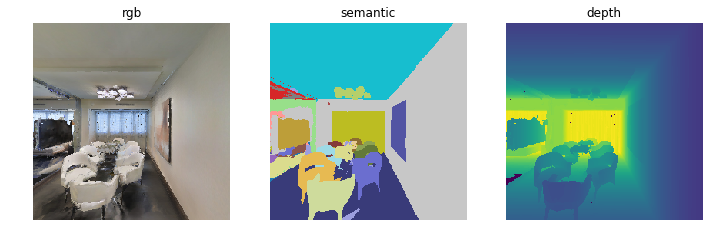

action turn_right


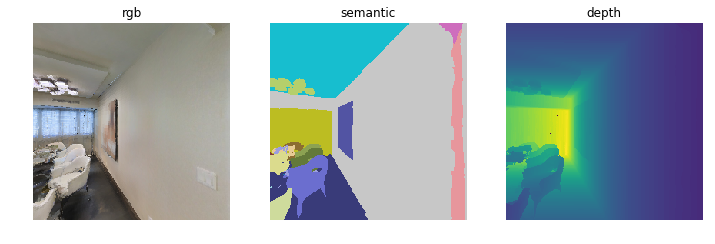

action move_forward


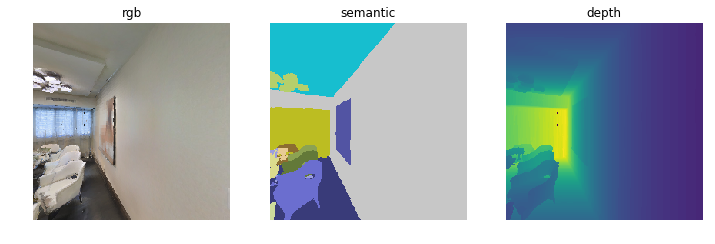

action turn_left


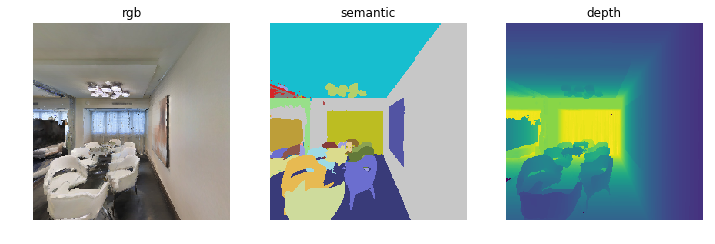

action move_forward


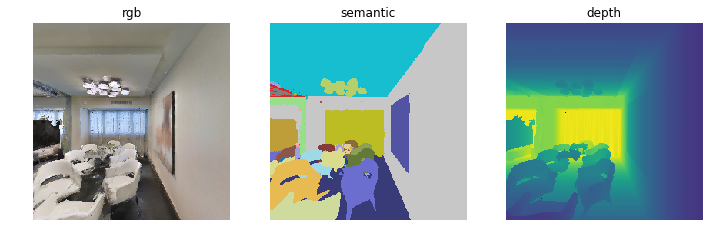

In [7]:
total_frames = 0
action_names = list(
    cfg.agents[
        sim_settings["default_agent"]
    ].action_space.keys()
)

max_frames = 5

while total_frames < max_frames:
    action = random.choice(action_names)
    print("action", action)
    observations = sim.step(action)
    rgb = observations["color_sensor"]
    semantic = observations["semantic_sensor"]
    depth = observations["depth_sensor"]
    
    display_sample(rgb, semantic, depth)
    
    total_frames += 1